In [1]:
# preliminary-analysis-2022.ipynb
#
# Bryan Daniels
# 2022/4/22
#
# Load newer Zenodo data (https://doi.org/10.5281/zenodo.6045859) to begin
# to see how we might infer predictors of foraging and comb-building.
#
# Using example at:
# https://github.com/jacobdavidson/bees_lifetimetracking_2018data/blob/main/Data%20usage%20example.ipynb
#

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [120]:
daynum = 42 #52

if daynum > 50:
    datadir = '../Data/220422/zenodo/beetrajectories_days_050_to_085/'
else:
    datadir = '../Data/220422/zenodo/beetrajectories_days_000_to_049/'

df = pd.read_hdf('{}beetrajectories_{:0>3}.hdf'.format(datadir,daynum))

In [9]:
len(df)

14866599

In [68]:
df

,daynum,framenum,uid,x,y,camera,theta
0,52,9197,1697,1175,4839,0,3.021990
1,52,9198,1697,1185,4863,0,1.907100
2,52,9199,1697,1201,4871,0,1.160400
3,52,9200,1697,1209,4872,0,0.950683
4,52,9201,1697,1201,4863,0,0.872222
...,...,...,...,...,...,...,...
14866594,52,256861,5342,1830,1417,0,-0.278046
14866595,52,256862,5342,1838,1417,0,-0.249975
14866596,52,257259,5342,1855,1417,0,-0.544705
14866597,52,257260,5342,1838,1433,0,-0.311755


Text(0, 0.5, 'Number of bees')

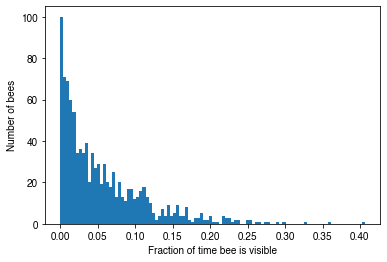

In [75]:
# what fraction of time is each bee visible?
# (note that bees are also going in and out of the hive)
plt.hist(df.groupby('uid').count()['framenum']/len(df.framenum.unique()),bins=100);
plt.xlabel('Fraction of time bee is visible')
plt.ylabel('Number of bees')

In [77]:
print("mean number of bees identified per framenum = {}".format(len(df)/len(df.framenum.unique())))
print("total number of unique bees = {}".format(len(df.uid.unique())))

mean number of bees identified per framenum = 57.35570601851852
total number of unique bees = 1008


<AxesSubplot:xlabel='framenum', ylabel='camera'>

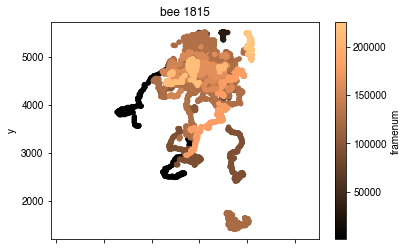

<Figure size 432x288 with 0 Axes>

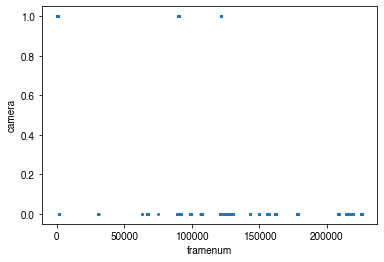

In [61]:
# select a single bee
bee_idx = 3
day_uids = np.unique(df['uid'])
bee_uid = day_uids[bee_idx]
dfsel = df[df['uid']==bee_uid]

# plot locations
# (note that this does not distinguish between the two cameras --- front and back of frame)
dfsel.plot.scatter('x','y',c='framenum',cmap=plt.colormaps['copper'])
plt.axis('equal')
plt.xlabel('x')
plt.title('bee {}'.format(bee_uid))

# plot times
plt.figure()
#plt.plot(np.arange(len(dfsel)),dfsel['framenum'],',')
dfsel.plot.scatter('framenum','camera',s=1)

In [ ]:
plt.plot(np.arange(len(dfsel)),dfsel['framenum'],',')

# Can we select bees initiating foraging and ask what they were doing differently leading up to that decision?

In [78]:
# Questions for Michael:
#     Do we have access to data for comb-building?
#     To what extent can we measure or infer interactions or proximity between specific bees?

In [80]:
# Defining foraging bees:
#          -- Looks like their definition of 'leaving the nest' is given in datafunctions.get_inout_estimates
#          -- In my previous preliminary analysis, I was using 'Num. outside trips', which is defined in 
#             'Data processing - 1 - metrics and dataframes.ipynb' as the number of times the bee's status 
#             changes from in-hive to out-of-hive (as measured by the `all_inhive` output of get_inout_estimates)
#          -- Note: get_inout_estimates takes as input a `dfday` dataframe, which summarizes data from a 
#             given day (e.g. in 5-minute chunks, if I remember right).  So we would have to rewrite if we want
#             to use a finer time resolution
#          -- get_inout_estimates uses 'Exit distance (median)', which is calculated using 
#             dfunc.getexitdistance(x,y,camera) (e.g. in 'Data processing - 1 - metrics and dataframes.ipynb')
#          -- So the question is whether we want to define foraging trips on a finer temporal scale than what 
#             has already been calculated (perhaps not, if data are intermittent at very short timescales)
#          -- Okay, looks like they have computed down to the level of 1 minute bins (these are computed in 
#             the section `(2) Create data matrix and save as df for each time division` of
#             'Data processing - 1 - metrics and dataframes.ipynb')

from bees_lifetimetracking_2018data import datafunctions

In [105]:
# find foragers at finest time resolution we currently have (1 minute)
dataDir = '../Data/220422/zenodo/df_day1min_alldays/'
dfday = pd.read_hdf(dataDir+'df_day1min_42.hdf')
numtimedivs = len(dfday['timedivision'].unique())
day_uids, day_ages, all_inhive, bee_obs, bee_exitdist = datafunctions.get_inout_estimates(dfday,
                                                                                          numtimedivs=numtimedivs)

In [111]:
# calculate times at which each bee leaves the hive
leave_hive_times_list = [ np.where(diffs==+1)[0] for diffs in np.diff(all_inhive) ]

In [123]:
# make dataframe consisting of each leaving event
leave_hive_times_by_uid = []
for uid,leave_hive_times in zip(day_uids,leave_hive_times_list):
    for leave_hive_time in leave_hive_times:
        leave_hive_times_by_uid.append([uid,leave_hive_time])
df_leave_hive_events = pd.DataFrame(leave_hive_times_by_uid,columns=['uid','leave hive time'])

# translate time to framenum (assuming 3 frames per second)
frames_per_day = 24*60*60*3
frames_per_timedivision = frames_per_day / numtimedivs
df_leave_hive_events['leave hive framenum'] = df_leave_hive_events['leave hive time']*frames_per_timedivision

In [128]:
dfday.columns

Index(['Age', 'Num. observations', 'Honey', 'Brood care', 'Pollen',
       'Dance floor', 'Other', 'Frame 0', 'Frame 1', 'Frame 2', 'Frame 3',
       'Frame 4', 'Frame 5', 'Median speed', 'Speed IQR',
       'Speed 90th quantile', 'Dispersion (avg)', 'Exit distance (median)',
       'Fraction squares visited', 'Day number', 'Festoon', 'Empty comb',
       'blank1', 'blank2', 'Bee unique ID', 'Cohort ID', 'Num. outside trips',
       'Num. dance floor visits', 'Dispersion-minute avg.',
       'Frame 0 - Num. crossings', 'Frame 1 - Num. crossings',
       'Frame 2 - Num. crossings', 'Frame 3 - Num. crossings',
       'Frame 4 - Num. crossings', 'Frame 5 - Num. crossings', 'timedivision'],
      dtype='object')

In [134]:
# TO DO NEXT: Use the following type of logic to calculate the distance of the bee from the exit
# for each "leave hive" event defined below
dfday[np.logical_and(dfday['Bee unique ID']==1359,dfday['timedivision']==978)]['Exit distance (median)']

1500252    0.0
Name: Exit distance (median), dtype: float64

In [124]:
df_leave_hive_events

,uid,leave hive time,leave hive framenum
0,1359,978,176040.0
1,1563,1077,193860.0
2,1563,1122,201960.0
3,1563,1149,206820.0
4,1563,1153,207540.0
...,...,...,...
279,4765,1419,255420.0
280,4776,720,129600.0
281,4828,804,144720.0
282,4883,750,135000.0


In [ ]:
# sanity check: is each bee close to the exit just before it leaves the hive?
df_leave_hive_events['Exit distance (median)'] = 

In [121]:
df

,daynum,framenum,uid,x,y,camera,theta
0,42,4913,1543,2406,4599,0,-1.63737
1,42,4914,1543,2407,4567,0,-1.89082
2,42,4915,1543,2390,4551,0,-1.89230
3,42,4916,1543,2382,4535,0,-2.23957
4,42,4917,1543,2390,4535,0,-2.22945
...,...,...,...,...,...,...,...
18055931,42,257243,4926,2142,3647,0,-1.85131
18055932,42,257244,4926,2158,3623,0,-1.54356
18055933,42,257245,4926,2142,3631,0,-2.12378
18055934,42,257246,4926,2118,3615,0,-1.99369
